In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import cv2
import scipy
from pathlib import Path
import h5py
import numpy as np
import torch
from torchvision import transforms
from scipy.signal.windows import gaussian
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset
import torch.fft
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.models as models
import copy

In [2]:
# Dataset path
dataset_path = Path("/kaggle/input/figshare-brain-tumor-dataset/dataset/data")

# Transform
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Storage
images = []
labels = []

# Helper to extract scalar from h5py
def read_scalar(h5obj):
    return int(np.array(h5obj)[0][0])

# Load .mat files
for file in dataset_path.glob("*.mat"):
    with h5py.File(file, 'r') as f:
        # The structure may look like: /cjdata/label, /cjdata/image, etc.
        label = read_scalar(f['cjdata']['label'])
        
        # cjdata.image is stored column-major (Fortran order), so we transpose it
        image = np.array(f['cjdata']['image']).T.astype(np.float32)
        image = ((image - image.min()) / (image.max() - image.min()) * 255).astype(np.uint8)
        image = np.stack([image]*3, axis=-1)  # Grayscale to RGB

        img_tensor = transform(image)
        images.append(img_tensor)
        labels.append(label)

# Convert to tensors
images_tensor = torch.stack(images)
labels_tensor = torch.tensor(labels)

print(f"Loaded {images_tensor.shape[0]} images.")
print(f"Sample image shape: {images_tensor[0].shape}")
print(f"Labels: {labels_tensor.unique().tolist()}")

Loaded 3064 images.
Sample image shape: torch.Size([3, 256, 256])
Labels: [1, 2, 3]


In [3]:
labels_tensor = torch.tensor(labels) - 1 # for model training purpose

In [4]:
print(f"Labels: {labels_tensor.unique().tolist()}")
print(images_tensor[0].shape)

Labels: [0, 1, 2]
torch.Size([3, 256, 256])


In [5]:
class Net(nn.Module):
    def __init__(self, threshold=10.0, use_cuda=False):
        super(Net, self).__init__()

        self.threshold = threshold
        self.use_cuda = use_cuda

        device = torch.device("cuda" if use_cuda else "cpu")

        filter_size = 5
        generated_filters = gaussian(filter_size, std=1.0).reshape([1, filter_size]).astype(np.float32)

        self.gaussian_filter_horizontal = nn.Conv2d(1, 1, kernel_size=(1, filter_size), padding=(0, filter_size // 2), bias=True)
        self.gaussian_filter_horizontal.weight.data.copy_(torch.from_numpy(generated_filters))
        self.gaussian_filter_horizontal.bias.data.zero_()

        self.gaussian_filter_vertical = nn.Conv2d(1, 1, kernel_size=(filter_size, 1), padding=(filter_size // 2, 0), bias=True)
        self.gaussian_filter_vertical.weight.data.copy_(torch.from_numpy(generated_filters.T))
        self.gaussian_filter_vertical.bias.data.zero_()

        sobel_filter = np.array([[1, 0, -1],
                                 [2, 0, -2],
                                 [1, 0, -1]], dtype=np.float32)

        self.sobel_filter_horizontal = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=True)
        self.sobel_filter_horizontal.weight.data.copy_(torch.from_numpy(sobel_filter))
        self.sobel_filter_horizontal.bias.data.zero_()

        self.sobel_filter_vertical = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=True)
        self.sobel_filter_vertical.weight.data.copy_(torch.from_numpy(sobel_filter.T))
        self.sobel_filter_vertical.bias.data.zero_()

        # Directional filters
        filters = [np.array([[0, 0, 0], [0, 1, -1], [0, 0, 0]]),    # 0°
                   np.array([[0, 0, 0], [0, 1, 0], [0, 0, -1]]),   # 45°
                   np.array([[0, 0, 0], [0, 1, 0], [0, -1, 0]]),   # 90°
                   np.array([[0, 0, 0], [0, 1, 0], [-1, 0, 0]]),   # 135°
                   np.array([[0, 0, 0], [-1, 1, 0], [0, 0, 0]]),   # 180°
                   np.array([[-1, 0, 0], [0, 1, 0], [0, 0, 0]]),   # 225°
                   np.array([[0, -1, 0], [0, 1, 0], [0, 0, 0]]),   # 270°
                   np.array([[0, 0, -1], [0, 1, 0], [0, 0, 0]])]   # 315°

        all_filters = np.stack(filters).astype(np.float32)

        self.directional_filter = nn.Conv2d(1, 8, kernel_size=3, padding=1, bias=True)
        self.directional_filter.weight.data.copy_(torch.from_numpy(all_filters[:, None, :, :]))
        self.directional_filter.bias.data.zero_()

    def forward(self, img):
        img_r, img_g, img_b = img[:, 0:1], img[:, 1:2], img[:, 2:3]

        def blur(channel):
            return self.gaussian_filter_vertical(self.gaussian_filter_horizontal(channel))

        blurred_img_r = blur(img_r)
        blurred_img_g = blur(img_g)
        blurred_img_b = blur(img_b)

        blurred_img = torch.stack([blurred_img_r, blurred_img_g, blurred_img_b], dim=1).squeeze(0)

        def grad(channel):
            return self.sobel_filter_horizontal(channel), self.sobel_filter_vertical(channel)

        grad_x_r, grad_y_r = grad(blurred_img_r)
        grad_x_g, grad_y_g = grad(blurred_img_g)
        grad_x_b, grad_y_b = grad(blurred_img_b)

        grad_mag = torch.sqrt(grad_x_r**2 + grad_y_r**2) + \
                   torch.sqrt(grad_x_g**2 + grad_y_g**2) + \
                   torch.sqrt(grad_x_b**2 + grad_y_b**2)

        grad_orientation = torch.atan2(
            grad_y_r + grad_y_g + grad_y_b,
            grad_x_r + grad_x_g + grad_x_b
        ) * (180.0 / np.pi)
        grad_orientation = torch.round((grad_orientation + 180.0) / 45.0) * 45.0

        all_filtered = self.directional_filter(grad_mag)

        indices_pos = (grad_orientation / 45) % 8
        indices_neg = ((grad_orientation / 45) + 4) % 8

        b, _, h, w = grad_mag.size()
        pixel_count = h * w
        range_ = torch.arange(pixel_count, device=img.device)

        flat_filtered = all_filtered.view(8, -1)

        pos_idx = (indices_pos.view(-1) * pixel_count + range_).long()
        neg_idx = (indices_neg.view(-1) * pixel_count + range_).long()

        pos = flat_filtered.view(-1)[pos_idx].view(1, h, w)
        neg = flat_filtered.view(-1)[neg_idx].view(1, h, w)

        is_max = torch.min(torch.stack([pos, neg]), dim=0)[0] > 0
        is_max = is_max.unsqueeze(0)

        thin_edges = grad_mag.clone()
        thin_edges[~is_max] = 0

        thresholded = thin_edges.clone()
        thresholded[thin_edges < self.threshold] = 0

        early_threshold = grad_mag.clone()
        early_threshold[grad_mag < self.threshold] = 0

        return blurred_img, grad_mag, grad_orientation, thin_edges, thresholded, early_threshold


def canny(img_tensor, use_cuda=False):
    device = torch.device("cuda" if use_cuda else "cpu")
    net = Net(threshold=3.0, use_cuda=use_cuda).to(device)
    net.eval()

    img_tensor = img_tensor.to(device).unsqueeze(0)  # add batch dimension
    with torch.no_grad():
        return net(img_tensor)

In [6]:
def canny(img_tensor, use_cuda=False):
    device = torch.device("cuda" if use_cuda else "cpu")
    net = Net(threshold=3.0, use_cuda=use_cuda).to(device)
    net.eval()

    img_tensor = img_tensor.to(device).unsqueeze(0)  # add batch dimension
    with torch.no_grad():
        return net(img_tensor)

In [7]:
def apply_canny_edge_detection(image, low_threshold=40, high_threshold=100):
    # Convert PyTorch tensor (CHW or HWC) to NumPy (H x W x C)
    if isinstance(image, torch.Tensor):
        if image.dim() == 3 and image.shape[0] == 3:  # CHW format
            image = image.permute(1, 2, 0)  # Convert to HWC
        image = image.cpu().numpy()

    # Convert to grayscale if RGB
    if image.ndim == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Normalize and convert to uint8 (0-255)
    image = (image * 255).astype(np.uint8) if image.max() <= 1.0 else image.astype(np.uint8)

    # Apply Canny
    edges = cv2.Canny(image, low_threshold, high_threshold)
    return torch.tensor(edges, dtype=torch.float32) / 255.0  # Normalize back if needed

In [8]:
def to_3ch(tensor):
    """
    Converts a tensor of shape [1, 1, H, W] or [1, H, W] to [3, H, W]
    """
    if tensor.dim() == 4:
        tensor = tensor[0, 0]  # [1, 1, H, W] → [H, W]
    elif tensor.dim() == 3:
        tensor = tensor[0]     # [1, H, W] → [H, W]

    tensor = tensor.float().cpu()                     # move to CPU and ensure float
    tensor_3ch = tensor.unsqueeze(0).repeat(3, 1, 1)  # [H, W] → [1, H, W] → [3, H, W]
    return tensor_3ch

In [ ]:
images_tensor[0].shape

In [ ]:
#blurred_img, grad_mag, grad_orientation, thin_edges, thresholded, early_threshold = canny(images_tensor[0], use_cuda=True)
#thresholded = to_3ch(thresholded)

In [9]:
images_tensor.shape

torch.Size([3064, 3, 256, 256])

In [10]:
def apply_canny_to_batch(images_tensor, use_cuda=False):
    canny_images = []
    for i in range(images_tensor.shape[0]):
        img = images_tensor[i]
        _, _, _, _, thresholded, _ = canny(img, use_cuda=use_cuda)  # Apply canny
        thresholded_3ch = to_3ch(thresholded)
        canny_images.append(thresholded_3ch)

    # Stack all processed images into tensor [N, 3, H, W]
    canny_images_tensor = torch.stack(canny_images)

    return canny_images_tensor

In [11]:
def apply_canny_to_batch_cv2_implementation(images_tensor):
    canny_images = []
    for i in range(images_tensor.shape[0]):
        img = images_tensor[i]
        edge_image = apply_canny_edge_detection(img)  # shape: [1, 256, 256]
        edge_image = edge_image.unsqueeze(0) if edge_image.dim() == 2 else edge_image  # [1, H, W]
        edge_image_3ch = edge_image.repeat(3, 1, 1)  # Repeat grayscale to make it 3 channels
        canny_images.append(edge_image_3ch)
    canny_images_tensor = torch.stack(canny_images)
    return canny_images_tensor  # shape: [batch_size, 3, 256, 256]

In [12]:
 # canny_images_tensor = apply_canny_to_batch(images_tensor, use_cuda=True)

canny_images_tensor = apply_canny_to_batch_cv2_implementation(images_tensor)

In [13]:
canny_images_tensor[0].shape

torch.Size([3, 256, 256])

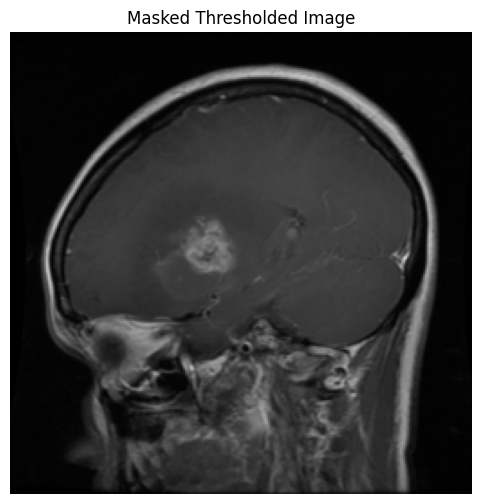

In [14]:


# Assuming masked_thresholded is your tensor with shape [3, 256, 256]

# Convert tensor to PIL Image for proper display
img_pil = TF.to_pil_image(images_tensor[2].cpu())

plt.figure(figsize=(6,6))
plt.imshow(img_pil)
plt.title("Masked Thresholded Image")
plt.axis('off')
plt.show()

In [15]:
# now we have to find fouriertransform of that canny-images-tensor
def high_pass_filter_fft(image_tensor, cutoff=5):
    """
    Apply high-pass filter using FFT on a single 3xHxW image.
    """
    # Convert to grayscale by averaging across channels
    grayscale = image_tensor.mean(dim=0)  # shape: [H, W]

    # FFT
    f = torch.fft.fft2(grayscale)
    fshift = torch.fft.fftshift(f)

    # Create high-pass filter mask
    H, W = grayscale.shape
    y, x = torch.meshgrid(torch.arange(H), torch.arange(W), indexing='ij')
    center_y, center_x = H // 2, W // 2
    distance = torch.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)
    mask = (distance > cutoff).float()

    # Apply high-pass filter
    fshift_filtered = fshift * mask

    # Inverse FFT
    f_ishift = torch.fft.ifftshift(fshift_filtered)
    img_back = torch.fft.ifft2(f_ishift).real

    # Normalize and repeat to 3 channels
    img_back = (img_back - img_back.min()) / (img_back.max() - img_back.min() + 1e-8)
    img_back_3ch = img_back.unsqueeze(0).repeat(3, 1, 1)

    return img_back_3ch


def apply_high_pass_filter_batch(canny_images_tensor, cutoff=5):
    """
    Apply high-pass filtering to a batch of canny-processed images.
    """
    filtered_images = []
    for img in canny_images_tensor:
        filtered = high_pass_filter_fft(img, cutoff)
        filtered_images.append(filtered)

    return torch.stack(filtered_images)  # [N, 3, H, W]

In [47]:
#fourier_canny_images_tensor = apply_high_pass_filter_batch(canny_images_tensor)
fourier_original_images_tensor = apply_high_pass_filter_batch(images_tensor, 10)

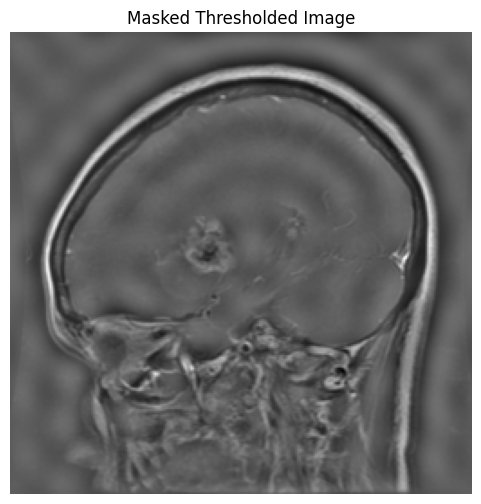

In [48]:


# Assuming masked_thresholded is your tensor with shape [3, 256, 256]

# Convert tensor to PIL Image for proper display
img_pil = TF.to_pil_image(fourier_original_images_tensor[2].cpu())

plt.figure(figsize=(6,6))
plt.imshow(img_pil)
plt.title("Masked Thresholded Image")
plt.axis('off')
plt.show()

In [49]:


class CustomTensorDataset(Dataset):
    def __init__(self, images_tensor, labels_tensor, transform=None):
        self.images = images_tensor
        self.labels = labels_tensor
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [50]:


mri_augmentation = transforms.Compose([
    transforms.RandomAffine(
        degrees=10,
        translate=(0.05, 0.05),
        scale=(0.95, 1.05),
        shear=5
    ),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.RandomErasing(p=0.2, scale=(0.01, 0.03), ratio=(0.3, 3.3), value=0),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

In [51]:
#custom_dataset = CustomTensorDataset(images_tensor, labels_tensor, mri_augmentation) # here the transform is for data augmentation
# if we want to apply any data-augmentation, we can do it here inside transform

# Example: get first image and label
#image, label = custom_dataset[0]

In [52]:
#fourier_canny_images_dataset = CustomTensorDataset(fourier_canny_images_tensor, labels_tensor)
canny_images_dataset = CustomTensorDataset(canny_images_tensor, labels_tensor)
custom_dataset = CustomTensorDataset(images_tensor, labels_tensor)
fourier_original_images_dataset = CustomTensorDataset(fourier_original_images_tensor, labels_tensor)

In [53]:


def split_dataset(custom_dataset, train_ratio=0.7, val_ratio=0.2, seed=42):
    """
    Splits a dataset into train, validation, and test sets based on provided ratios.

    Args:
        custom_dataset (Dataset): The full dataset to be split.
        train_ratio (float): Proportion of dataset to use for training.
        val_ratio (float): Proportion of dataset to use for validation.
        seed (int): Seed for reproducibility.

    Returns:
        tuple: (train_data, val_data, test_data)
    """
    total_size = len(custom_dataset)
    generator = torch.Generator().manual_seed(seed)

    train_size = int(train_ratio * total_size)
    val_size = int(val_ratio * total_size)
    test_size = total_size - train_size - val_size  # Ensure full coverage

    train_data, val_data, test_data = random_split(
        custom_dataset, [train_size, val_size, test_size], generator=generator
    )

    print(f"Train: {len(train_data)}, Validation: {len(val_data)}, Test: {len(test_data)}")
    return train_data, val_data, test_data

In [54]:
# previouse data-split code
# from torch.utils.data import random_split

# Set the seed for reproducibility (optional)
# generator = torch.Generator().manual_seed(42)

# Get total size
# total_size = len(custom_dataset)

# Calculate split lengths
# train_size = int(0.7 * total_size)
# val_size = int(0.2 * total_size)
# test_size = total_size - train_size - val_size  # ensure full coverage

# Split the dataset
# train_data, val_data, test_data = random_split(custom_dataset, [train_size, val_size, test_size], generator=generator)

# print(f"Train: {len(train_data)}, Validation: {len(val_data)}, Test: {len(test_data)}")

In [55]:
# fourier_canny_train_data, fourier_canny_val_data, fourier_canny_test_data = split_dataset(fourier_canny_images_dataset) #70% training, 20% validation and 10% testing
canny_train_data, canny_val_data, canny_test_data = split_dataset(canny_images_dataset)
train_data, val_data, test_data = split_dataset(custom_dataset)
fourier_original_images_train_data, fourier_original_images_val_data, fourier_original_images_test_data = split_dataset(fourier_original_images_dataset)

Train: 2144, Validation: 612, Test: 308
Train: 2144, Validation: 612, Test: 308
Train: 2144, Validation: 612, Test: 308


In [56]:
def print_class_distribution(dataset, datasetname):
    counter = {0:0, 1:0, 2:0}
    for data in dataset:
        num = data[1].item()
        counter[num] = counter[num] + 1
    print(datasetname, "class 0", counter[0])
    print(datasetname, "class 1", counter[1])
    print(datasetname, "class 2", counter[2])
#print_class_distribution(train_data, "train")
#print_class_distribution(val_data, "validation")
#print_class_distribution(test_data, "test_data")

In [57]:


# Set your desired batch size
batch_size = 32

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Create DataLoaders
fourier_original_images_train_loader = DataLoader(fourier_original_images_train_data, batch_size=batch_size, shuffle=True)
fourier_original_images_val_loader = DataLoader(fourier_original_images_val_data, batch_size=batch_size, shuffle=False)
fourier_original_images_test_loader = DataLoader(fourier_original_images_test_data, batch_size=batch_size, shuffle=False)

#fourier_canny_train_loader = DataLoader(fourier_canny_train_data, batch_size=batch_size, shuffle=True)
#fourier_canny_val_loader = DataLoader(fourier_canny_val_data, batch_size=batch_size, shuffle=False)
#fourier_canny_test_loader = DataLoader(fourier_canny_test_data, batch_size=batch_size, shuffle=False)

#canny_train_loader = DataLoader(canny_train_data, batch_size=batch_size, shuffle=True)
#canny_val_loader = DataLoader(canny_val_data, batch_size=batch_size, shuffle=False)
#canny_test_loader = DataLoader(canny_test_data, batch_size=batch_size, shuffle=False)

# (Optional) Check number of batches
#print(f"Train batches: {len(train_loader)}")
#print(f"Validation batches: {len(val_loader)}")
#print(f"Test batches: {len(test_loader)}")

In [58]:
# lets print our accelerator cuda-gpu, if that is not found go for cpu
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"using device {device}") # we are using gpu

using device cuda


In [59]:
# Number of classes (update this based on your problem)
num_classes = 3

# Define the model
class CustomResNet50(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet50, self).__init__()
        # Load pretrained ResNet-50
        self.base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        
        # Freeze all layers
        for param in self.base_model.parameters():
            param.requires_grad = False
            
        # Replace the top layer (classifier head)
        self.base_model.fc = nn.Sequential(
            nn.Linear(self.base_model.fc.in_features, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        
        # Unfreeze the classifier head parameters
        for param in self.base_model.fc.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.base_model(x)


In [60]:
custom_resnet50_model = CustomResNet50(num_classes=num_classes).to(device)
fourier_original_images_resnet50_model = CustomResNet50(num_classes=num_classes).to(device)
#fourier_canny_custom_resnet50_model = CustomResNet50(num_classes=num_classes).to(device)
#canny_custom_resnet50_model = CustomResNet50(num_classes=num_classes).to(device)

In [61]:
#print(custom_resnet50_model)

In [62]:
# now we need a loss function(to calculate error) and an optimizer(or gradient descent algorithm)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(custom_resnet50_model.parameters(), lr=1e-4)

fourier_original_lossfunction = nn.CrossEntropyLoss()
fourier_original_optimizer = torch.optim.Adam(fourier_original_images_resnet50_model.parameters(), lr=1e-4)
# we are taking adam as optimizer

#fourier_canny_loss_function = nn.CrossEntropyLoss()
#fourier_canny_optimizer = torch.optim.Adam(fourier_canny_custom_resnet50_model.parameters(), lr=1e-4)

#canny_loss_function = nn.CrossEntropyLoss()
#canny_optimizer = torch.optim.Adam(canny_custom_resnet50_model.parameters(), lr=1e-4)

In [63]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 32 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [64]:
def validation(dataloader, model, loss_fn, return_metrics=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    validation_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
           # print("pred", pred, pred.shape)
            validation_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item() # here 1 means search for max value through the column for each row
    validation_loss /= num_batches
    correct /= size
    accuracy = 100 * correct
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {validation_loss:>8f} \n")
    if return_metrics:
        return validation_loss, accuracy

In [65]:
def runEpochAndFinalTest(epochs, model, loss_function, optimizers, train_loader, val_loader, test_loader, model_name):

    best_val_acc = 0.0  # Or use float('inf') for best_val_loss
    best_model_state = None  # To store best model
    model_save_path = model_name + "best_model.pth"
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_loader, model, loss_function, optimizers)
        val_loss, val_acc = validation(val_loader, model, loss_function, return_metrics=True)
        # Save best model based on validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())
            torch.save(best_model_state, model_save_path)
            print(f"✅ Best model saved at epoch {t + 1} with accuracy: {val_acc:.4f}")
        print("Done!")
    model.load_state_dict(torch.load(model_save_path))
    model.eval()
    validation(test_loader, model, loss_function) # final test_data accuracy check

In [66]:
#runEpochAndFinalTest(50, fourier_canny_custom_resnet50_model, fourier_canny_loss_function, fourier_canny_optimizer, fourier_canny_train_loader, fourier_canny_val_loader, fourier_canny_test_loader, model_name = "fourier_canny_")
#runEpochAndFinalTest(50, canny_custom_resnet50_model, canny_loss_function, canny_optimizer, canny_train_loader, canny_val_loader, canny_test_loader, model_name = "canny_")
runEpochAndFinalTest(50, fourier_original_images_resnet50_model, fourier_original_lossfunction, 
                     fourier_original_optimizer, fourier_original_images_train_loader, fourier_original_images_val_loader, fourier_original_images_test_loader, model_name = "normal_MRI_to_Fourier_Model")
runEpochAndFinalTest(50, custom_resnet50_model, loss_function, optimizer, train_loader, val_loader, test_loader, model_name = "normal_MRI_model")

Epoch 1
-------------------------------
loss: 1.069026  [   32/ 2144]
loss: 0.735362  [ 1056/ 2144]
loss: 0.524270  [ 2080/ 2144]
Test Error: 
 Accuracy: 56.7%, Avg loss: 0.748450 

✅ Best model saved at epoch 1 with accuracy: 56.6993
Done!
Epoch 2
-------------------------------
loss: 0.479846  [   32/ 2144]
loss: 0.642886  [ 1056/ 2144]
loss: 0.448285  [ 2080/ 2144]
Test Error: 
 Accuracy: 78.6%, Avg loss: 0.506851 

✅ Best model saved at epoch 2 with accuracy: 78.5948
Done!
Epoch 3
-------------------------------
loss: 0.287590  [   32/ 2144]
loss: 0.451867  [ 1056/ 2144]
loss: 0.481165  [ 2080/ 2144]
Test Error: 
 Accuracy: 84.5%, Avg loss: 0.418462 

✅ Best model saved at epoch 3 with accuracy: 84.4771
Done!
Epoch 4
-------------------------------
loss: 0.352185  [   32/ 2144]
loss: 0.274475  [ 1056/ 2144]
loss: 0.481571  [ 2080/ 2144]
Test Error: 
 Accuracy: 86.8%, Avg loss: 0.411938 

✅ Best model saved at epoch 4 with accuracy: 86.7647
Done!
Epoch 5
----------------------------

In [ ]:
# saving the model
#torch.save(custom_resnet50_model.state_dict(), "resnet_50_imagenet_transfer_learning_model_on_normal_image.pth")
#print("saved model")